## Import

In [143]:
seed = 42

#from sklearnex import patch_sklearn
#patch_sklearn()

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score

import pickle

## Caricamento dati

In [167]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


In [168]:
# Specifica il percorso del file CSV
#csv_path = '../CSV/Encoders3D/RESNET50_3D.csv'  # Sostituisci con il tuo percorso
csv_path = r'\Users\bsbar\Desktop\RESNET50_3D.csv'
# Carica il CSV in un DataFrame
df = pd.read_csv(csv_path)

# Ordina il DataFrame in base alla colonna 'Paziente'
df_sorted = df.sort_values(by='Patient')

# Estrai le colonne delle features (escludendo la colonna 'Paziente')
df_features = df_sorted.drop(columns=['Patient'])

features= df_features.to_numpy()
# Mostra il risultato
print(features.shape)
print(features[0])

(129, 2048)
[293.5498     0.       235.62929  ...   9.275444   0.       142.97008 ]


## Funzioni Varie

In [189]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values <= alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


In [205]:
## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="selector", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "selector":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test

        number_features = len(selected_features)  # Numero di feature selezionate
        #print("Ho scelto le features: ", selected_features)

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)

    elif mode == "features":  # Non fa feature selection ma usa le selected_features passate
        if selected_features is None or len(selected_features) == 0:
            print("Error: selected_features must be provided in 'features' mode.")
            return
        
        #print("Testo sulle features:  ", selected_features)
        # Usa solo le selected features su train e test
        X_selected = x_train_expanded[:, selected_features]
        x_test = x_test[:, selected_features]

        number_features = len(selected_features)

        # Training del classificatore su train + validation
        classifier.fit(X_selected, y_train_expanded)
    
    else:
           print("Errore, scegliere tra: selector / features")

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)


            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold,
                    'balanced accuracy': bal_acc
                }

    return best_case


#####################################################################################################################################

### questo ritorna le il vettore di probabilità senza fare la classificazione
def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if (len(selected_features)==0):
                    return [0],0,[0]
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features


#####################################################################################################################################


### classificazione effettuata con una threshold specifica
def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold,
                    'balanced accuracy': bal_acc
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case

#####################################################################################################################################


# metodo che definisce la threshold ottimale attraverso Youden's J statistic (threshold_selection= 'y')
# oppure attraverso la distanza euclidea dalla curva ROC (threshold_selection= 'd')
def classification_method_selection(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, threshold_selection, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        classi=classifierinitialization(classifier, X_selected, y_train_expanded )
        # Training del classificatore
        classi.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]

    ## due modalità 
    if threshold_selection == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif threshold_selection == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)


    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': threshold_selection
    }

    return best_case

def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

## Split e correlation

In [217]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False)


print("Number of train patients: ", len(X_train))
print("Number of test patients: ", len(y_test))

print("Number of features for every image: ", X_train[0].shape[0] )


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  2048


In [219]:

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.8)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)


print(X_train_reduced.shape)
print(X_test_reduced.shape)


# RIMOZIONE FEATURES CON P_VALUE ELEVATO

X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=1)
X_test_reduced = X_test_reduced[:, features_to_keep]

print(X_train_reduced.shape)
print(X_test_reduced.shape)
print(len(X_train_reduced[4]))


(90, 416)
(39, 416)
(90, 48)
(39, 48)
48


## Parametri iniziali

In [220]:
alpha_den = np.linspace(0.0001, 0.01, 30).tolist() ## RANGE PER RESNET e INCEPETION

alpha_vgg = np.linspace(0.45, 5, 30).tolist() ## RANGE PER VGG

alpha_rad = np.linspace(0.001, 0.01, 30).tolist() ## range per radiomica


alpha_values=alpha_den
#alpha_values.remove(0.0)


#thresholds=np.arange(0.4, 0.61, 0.01) 

thresholds=[0.5]

#selectors=['lasso', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
#classifiers=['SVM', 'ensemble','RandomForest', 'Logistic']
selectors=['mrmr','rf', 'logistic', 'lasso']
#selectors = ['lasso']


## Loop

In [221]:

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None
            }


results_val_others = [template_dict.copy() for _ in range(5000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(5000)]
results_val_lasso.append(template_dict.copy())

results_test_others = [template_dict.copy() for _ in range(5000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(5000)]
results_test_lasso.append(template_dict.copy())
limit=30

smote = SMOTE(random_state=10)
 
k=0
u=0
n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)


### Selezione con selector e num features fissi

In [222]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    #X_train_reduced, Y_train = smote.fit_resample(X_train_reduced, Y_train)


    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)

                if(selector=='lasso'):

                    for alpha in alpha_values:
                        #print("Doing alpha ", alpha )
                        classi= classifierinitialization(classifier)
                        best_case_val= classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, mode="selector", selected_features=[0], thresholds=0.5)
                        
                        if(best_case_val==0):
                            continue
                        if(best_case_val['num_features']> limit):
                             continue
                        #print(best_case_val['num_features'])
                        results_val_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy'],
                                            }

                        #print(best_case_val['num_features'])
                        

                        if(fold_idx==0):
                            classi= classifierinitialization(classifier)
                            best_case_test= classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="selector", selected_features=[0], thresholds=0.5)

                            if(best_case_test==0):
                                continue
                            
                            results_test_lasso[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'pr_auc': best_case_test['pr_auc'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy'],
                                                }
                            u=u+1
                        k = k + 1

                else:
                    #limit=len(x_train_reduced[0]) 
                    limit=30
                    for t in range(1, limit):
                            #print(t)
                            classi= classifierinitialization(classifier)

                            best_case_val= classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, mode="selector", selected_features=[0], thresholds=0.5)
                    
                                
                            results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }
                            #print(results_val_others[k]['f1'])

                            if(fold_idx==0):
                                classi= classifierinitialization(classifier)
                                best_case_test= classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, t, mode="selector", selected_features=[0], thresholds=0.5)
                                
                                results_test_others[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'pr_auc': best_case_test['pr_auc'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy'],
                                                    }
                                u=u+1

                            k = k + 1

Starting with fold: 0
Starting with classifier: XgBoost
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: SVM
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: RandomForest
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: Logistic
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: MLP
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with fold: 1
Starting with classifier: XgBoost
Start

### Selezione con features fisse

In [75]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    #X_train_reduced, Y_train = smote.fit_resample(X_train_reduced, Y_train)


    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)

                if(selector=='lasso'):

                    for alpha in alpha_values:
                        #print("Doing alpha ", alpha )
                        classi= classifierinitialization(classifier)
                        best_case_val= classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, mode="selector", selected_features=[0], thresholds=0.5)
                        
                        if(best_case_val==0):
                            continue
                        if(best_case_val['num_features']> limit):
                             continue
                        
                        results_val_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy'],
                                            }

                        #print(best_case_val['num_features'])
                        

                        if(fold_idx==0):
                            classi= classifierinitialization(classifier)
                            best_case_test= classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="features", selected_features=best_case_val['selected_features'], thresholds=0.5)

                            if(best_case_test==0):
                                continue
                            
                            results_test_lasso[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'pr_auc': best_case_test['pr_auc'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy'],
                                                }
                            u=u+1
                        k = k + 1

                else:
                    #limit=len(x_train_reduced[0]) + 1
                    limit=30
                    for t in range(1, limit):
                            classi= classifierinitialization(classifier)

                            best_case_val= classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, mode="selector", selected_features=[0], thresholds=0.5)
                    
                                
                            results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }
                            #print(results_val_others[k]['f1'])

                            if(fold_idx==0):
                                classi= classifierinitialization(classifier)
                                best_case_test= classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, t, mode="features", selected_features=best_case_val['selected_features'], thresholds=0.5)
                                
                                results_test_others[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'pr_auc': best_case_test['pr_auc'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy'],
                                                    }
                                u=u+1

                            k = k + 1

Starting with fold: 0
Starting with classifier: XgBoost
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: SVM
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: RandomForest
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: Logistic
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: MLP
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: lasso
Starting with fold: 1
Starting with classifier: XgBoost
Start

### Eliminazione dizionari vuoti

In [223]:
results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['classifier'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")

Filtered results_test_lasso: 30 entries remaining
Filtered results_val_lasso: 150 entries remaining
Filtered results_test_others: 522 entries remaining
Filtered results_val_others: 2610 entries remaining


## Sorting per val

In [224]:
#num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

num_features_range = list(range(1, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        #print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_lasso[(classifier, selector, alpha)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

#sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']),reverse=True)
#sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']), reverse=True)





In [225]:
import functools

# Funzione di ordinamento personalizzata
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # Se la differenza tra le balanced accuracies è minore di 0.001, confronta la ROC AUC
    if abs(balacc1 - balacc2) < 0.002:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Confronta la ROC AUC e ritorna -1, 0 o 1 per l'ordinamento
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Altrimenti ordina per balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

# Combina i risultati di others e lasso
sorted_results = sorted_results_others + sorted_results_lasso

# Utilizza cmp_to_key per usare la funzione di comparazione personalizzata
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)


## Combinazione migliore

In [226]:
n=10
best_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")



   
    for p in range (0, len(results_test_lasso)):            
            if(params[1]=='lasso'):
                if(results_test_lasso[p]['classifier']==params[0] and results_test_lasso[p]['alpha']==params[2]):
                        best_case=results_test_lasso[p]
                        break
    for p in range (0, len(results_test_others)):    
                if(results_test_others[p]['classifier']==params[0] and results_test_others[p]['selector']==params[1] and results_test_others[p]['num_features']==params[2]):
                        best_case=results_test_others[p]
                        break

    
    print("Metrics on the TEST set:")

    print(f"Selected Features: {best_case['selected_features']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 10 combinazioni di parametri:

#1:
Classifier: SVM
Selector: lasso
Alpha: 0.008975862068965518
Performance medie sul val set: 
ROC AUC = 0.7750000000000001 (std = 0), Balanced Accuracy = 0.7875 (std = 0)
Metrics on the TEST set:
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10]
ROC AUC: 0.5462962962962964
F1 Score: 0.41379310344827586
Accuracy: 0.5641025641025641
Balanced Accuracy: 0.5462962962962963
Confusion Matrix: 
[[16 11]
 [ 6  6]]

#2:
Classifier: SVM
Selector: lasso
Alpha: 0.01
Performance medie sul val set: 
ROC AUC = 0.6563786008230453 (std = 0.16407284708796915), Balanced Accuracy = 0.712037037037037 (std = 0.09090947086527404)
Metrics on the TEST set:
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10]
ROC AUC: 0.5462962962962964
F1 Score: 0.41379310344827586
Accuracy: 0.5641025641025641
Balanced Accuracy: 0.5462962962962963
Confusion Matrix: 
[[16 11]
 [ 6  6]]

#3:
Classifier: SVM
Selector: lasso
Alpha: 0.009658620689655173
Performance medie sul val set: 
R

## Grafici

In [117]:
classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
selectors=['mrmr','rf', 'logistic', 'lasso']

best_results_class_selector_template={
    'classifier': None,
    'selector': None,
    'num_features/alpha': None,
    'avg_balaccuracy': None,
    'std_balaccuracy': None,
    'avg_roc_auc':None,
    'std_roc_auc': None
}

best_results_class_selector = [best_results_class_selector_template.copy() for _ in range(23)]
best_results_class_selector.append(best_results_class_selector_template.copy())

i = 0
for classifier in classifiers:
    for selector in selectors:
        for params, metrics in sorted_results:
            if params[0] == classifier and params[1] == selector:
                best_results_class_selector[i]['classifier'] = params[0]
                best_results_class_selector[i]['selector'] = params[1]
                best_results_class_selector[i]['num_features/alpha'] = params[2]
                
                # Verifica se i valori sono tuple o scalari e assegna correttamente
                best_results_class_selector[i]['avg_balaccuracy'] = metrics['avg_balaccuracy'][0] if isinstance(metrics['avg_balaccuracy'], tuple) else metrics['avg_balaccuracy']
                best_results_class_selector[i]['std_balaccuracy'] = metrics['std_balaccuracy'][0] if isinstance(metrics['std_balaccuracy'], tuple) else metrics['std_balaccuracy']
                best_results_class_selector[i]['avg_roc_auc'] = metrics['avg_roc_auc'][0] if isinstance(metrics['avg_roc_auc'], tuple) else metrics['avg_roc_auc']
                best_results_class_selector[i]['std_roc_auc'] = metrics['std_roc_auc'][0] if isinstance(metrics['std_roc_auc'], tuple) else metrics['std_roc_auc']
                
                i += 1
                break


In [118]:
metricaavg='avg_balaccuracy'
metricastd='std_balaccuracy'
metricanome= 'balanced accuracy'
labell='BA'

In [ ]:
metricaavg='avg_roc_auc'
metricastd='std_roc_auc'
metricanome= 'roc_auc'
labell='ROC'

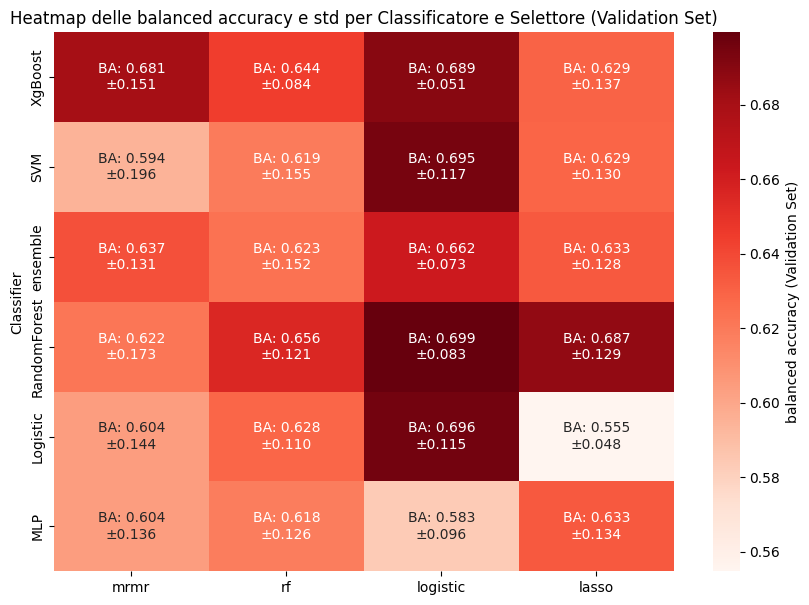

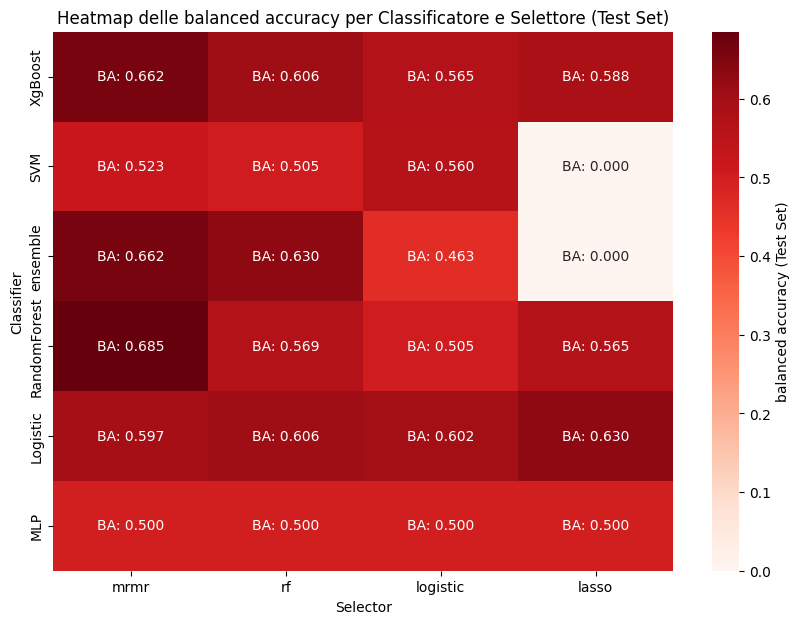

In [119]:
# Inizializza una matrice vuota per memorizzare le performance sul validation set
heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)


# Popola la matrice con i valori di avg_balaccuracy e annotazioni con std_balaccuracy
for result in best_results_class_selector:
    classifier = result['classifier']
    selector = result['selector']
    
    # Se classifier e selector non sono None, significa che abbiamo un risultato valido
    if classifier is not None and selector is not None:
        # Estrai i valori numerici
        avg_balaccuracy = result[metricaavg]
        std_balaccuracy = result[metricastd]
        
        # Inserisci la balanced accuracy del validation set nella heatmap
        heatmap_data.loc[classifier, selector] = avg_balaccuracy
        
        # Inserisci l'annotazione con la balanced accuracy e la deviazione standard
        annotations.loc[classifier, selector] = (
            f"{labell}: {avg_balaccuracy:.3f}\n"
            f"±{std_balaccuracy:.3f}"
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)

# Crea la heatmap con annotazioni
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Validation Set)'})
plt.title(f"Heatmap delle {metricanome} e std per Classificatore e Selettore (Validation Set)")
plt.ylabel('Classifier')
plt.show()



# Inizializza una matrice vuota per memorizzare le performance sul test set
heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)

# Ciclo attraverso best_results_class_selector per popolare la matrice con le metriche prese dal test set
u = 0
for result in best_results_class_selector:
    u += 1
    found = False
    classifier = result['classifier']
    selector = result['selector']
    num_features_alpha = result['num_features/alpha']
    
    # Cerca i risultati nel test set
    best_case = None
    if selector == 'lasso':
        for p in range(len(results_test_lasso)):
            if results_test_lasso[p]['classifier'] == classifier and results_test_lasso[p]['alpha'] == num_features_alpha:
                best_case = results_test_lasso[p]
                found = True
                break
    else:
        for p in range(len(results_test_others)): 
            if results_test_others[p]['classifier'] == classifier and results_test_others[p]['selector'] == selector and results_test_others[p]['num_features'] == num_features_alpha:
                best_case = results_test_others[p]
                found = True
                break
    
    # Se troviamo il miglior caso, popola la matrice con la Balanced Accuracy
    if found and best_case is not None:
        # Popola la matrice con la Balanced Accuracy
        heatmap_data.loc[classifier, selector] = best_case[metricanome]
        
        # Popola la matrice delle annotazioni con il testo "BA: <valore>"
        annotations.loc[classifier, selector] = f"{labell}: {best_case[metricanome]:.3f}"

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.fillna(0)
annotations = annotations.fillna(f"{labell}: 0.000")

# Crea la heatmap con Balanced Accuracy e annotazioni personalizzate
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Test Set)'})
plt.title(f"Heatmap delle {metricanome} per Classificatore e Selettore (Test Set)")
plt.ylabel('Classifier')
plt.xlabel('Selector')
plt.show()
